In [3]:
import shutil
import glob
import matplotlib.pyplot as plt
import json
import math
import cv2
import os

In [4]:
import json
import math
import os
import tensorflow as tf
import cv2
from PIL import Image
import numpy as np
from keras import layers
#!pip install keras.applications
from tensorflow.keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as pltConvolutional
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm

from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [5]:
os.mkdir('augmented400')

In [6]:
os.mkdir('./augmented400/benign')
os.mkdir('./augmented400/malignant')

In [7]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [8]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

def processing2(img_path):
    img = cv2.imread(img_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    image = cv2.medianBlur(image, 5)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    cv2.imwrite(img_path,image)

In [9]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1G7nnjrMvbWw-JARjG11xR8X84Z0HiGCF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1G7nnjrMvbWw-JARjG11xR8X84Z0HiGCF" -O FILENAME && rm -rf /tmp/cookies.txt
!unzip /content/FILENAME


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-026.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-027.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-028.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-029.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-030.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-031.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/mali

In [10]:
files_benign=getListOfFiles('/content/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png') and '400' in f:
        shutil.copy(f,'augmented400/benign')

In [11]:
files_malignant=getListOfFiles('/content/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png') and '400' in f:
        shutil.copy(f,'augmented400/malignant')

In [12]:
benign_train = np.array(Dataset_loader('/content/augmented400/benign',224))
malign_train = np.array(Dataset_loader('/content/augmented400/malignant',224))
benign_test = np.array(Dataset_loader('/content/augmented400/benign',224))
malign_test = np.array(Dataset_loader('/content/augmented400/malignant',224))

100%|██████████| 1232/1232 [00:18<00:00, 68.26it/s]


In [13]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [14]:
# Skin Cancer: Malignant vs. Benignmodel.save("/content")
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

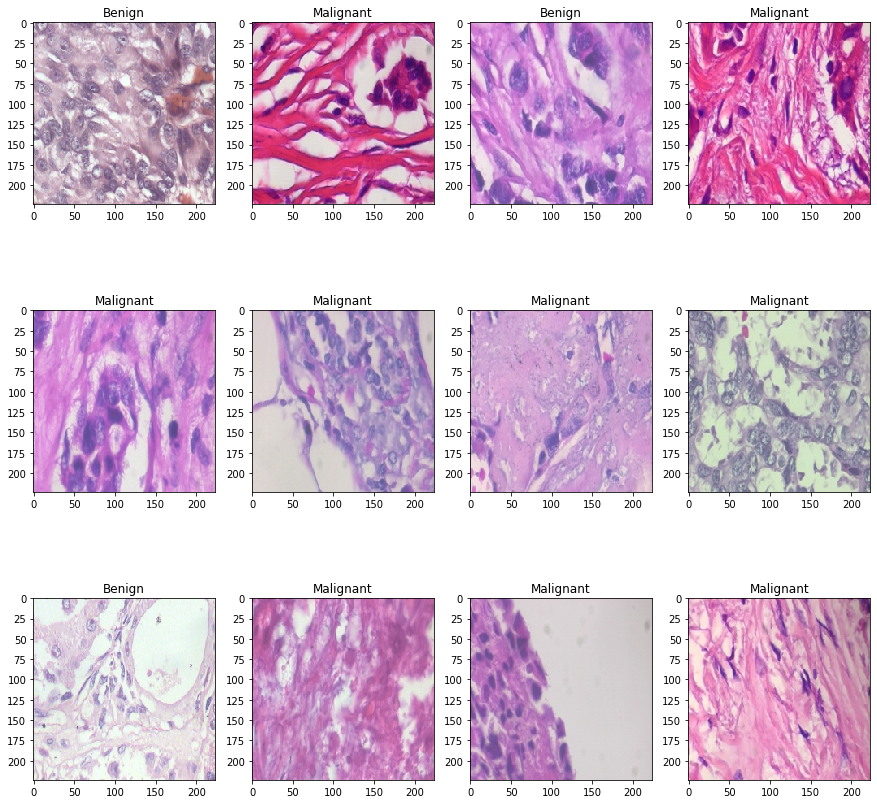

In [16]:
# Display first 15 images and their classification
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [17]:
BATCH_SIZE = 8

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [18]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [19]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

74850304/74836368 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [21]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)


Epoch 1/5
182/182 [==============================] - 144s 463ms/step - loss: 0.5782 - accuracy: 0.7356 - val_loss: 0.4835 - val_accuracy: 0.7335 - lr: 1.0000e-04
Epoch 2/5
182/182 [==============================] - 75s 412ms/step - loss: 0.4606 - accuracy: 0.8111 - val_loss: 0.3045 - val_accuracy: 0.8874 - lr: 1.0000e-04
Epoch 3/5
182/182 [==============================] - 75s 413ms/step - loss: 0.4113 - accuracy: 0.8297 - val_loss: 0.4210 - val_accuracy: 0.8764 - lr: 1.0000e-04
Epoch 4/5
182/182 [==============================] - 75s 411ms/step - loss: 0.3806 - accuracy: 0.8455 - val_loss: 0.2468 - val_accuracy: 0.8956 - lr: 1.0000e-04
Epoch 5/5
182/182 [==============================] - 75s 411ms/step - loss: 0.3499 - accuracy: 0.8530 - val_loss: 0.1646 - val_accuracy: 0.9313 - lr: 1.0000e-04


In [23]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

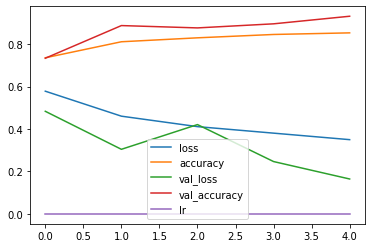

In [24]:
history_df = pd.DataFrame(history.history)
history_df.plot()

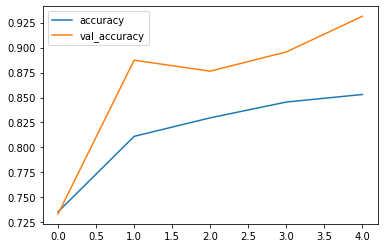

In [25]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

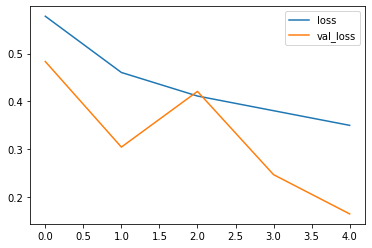

In [26]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [27]:
Y_val_pred = model.predict(x_val)

In [28]:
accuracy_score(np.argmax(y_val, axis = 1), np.argmax(Y_val_pred, axis = 1))

0.9313186813186813

In [29]:
Y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[ 498   90]
 [  28 1204]]


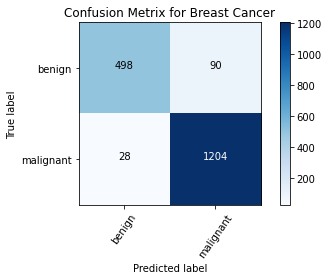

In [30]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1),np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

In [34]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.85      0.89       588
           1       0.93      0.98      0.95      1232

    accuracy                           0.94      1820
   macro avg       0.94      0.91      0.92      1820
weighted avg       0.94      0.94      0.93      1820



In [32]:
for elt in classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)):
  print(elt)

 
 
 
 
 
 
 
 
 
 
 
 
 
 
p
r
e
c
i
s
i
o
n
 
 
 
 
r
e
c
a
l
l
 
 
f
1
-
s
c
o
r
e
 
 
 
s
u
p
p
o
r
t




 
 
 
 
 
 
 
 
 
 
 
0
 
 
 
 
 
 
 
0
.
9
5
 
 
 
 
 
 
0
.
8
5
 
 
 
 
 
 
0
.
8
9
 
 
 
 
 
 
 
5
8
8


 
 
 
 
 
 
 
 
 
 
 
1
 
 
 
 
 
 
 
0
.
9
3
 
 
 
 
 
 
0
.
9
8
 
 
 
 
 
 
0
.
9
5
 
 
 
 
 
 
1
2
3
2




 
 
 
 
a
c
c
u
r
a
c
y
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0
.
9
4
 
 
 
 
 
 
1
8
2
0


 
 
 
m
a
c
r
o
 
a
v
g
 
 
 
 
 
 
 
0
.
9
4
 
 
 
 
 
 
0
.
9
1
 
 
 
 
 
 
0
.
9
2
 
 
 
 
 
 
1
8
2
0


w
e
i
g
h
t
e
d
 
a
v
g
 
 
 
 
 
 
 
0
.
9
4
 
 
 
 
 
 
0
.
9
4
 
 
 
 
 
 
0
.
9
3
 
 
 
 
 
 
1
8
2
0




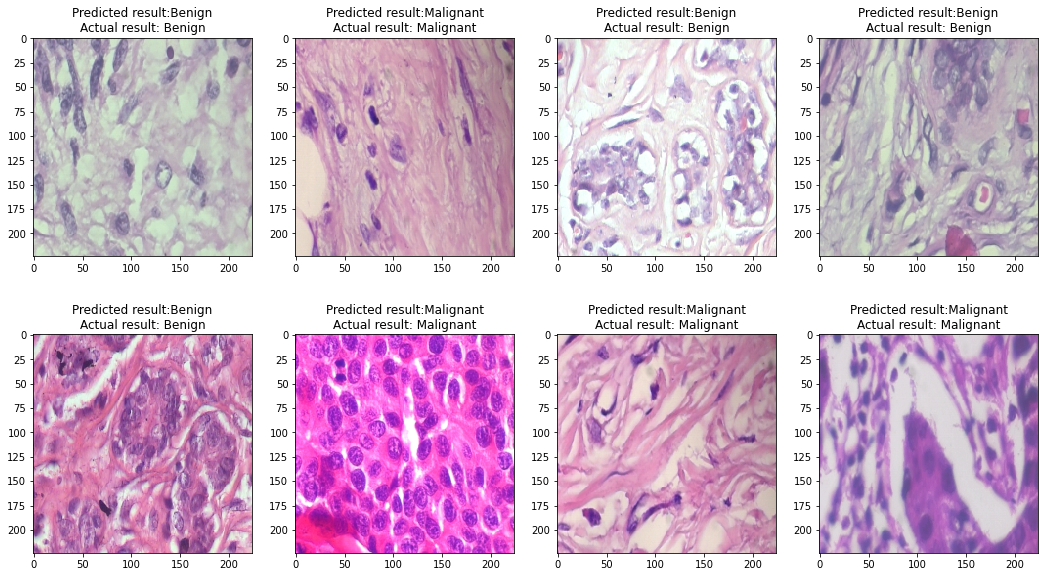

In [33]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()